# Read out data from Database, get preview URL-s and save to file
## This should be run only once

In [ ]:
import sqlite3
from spotify_preview import get_spotify_preview_url
import pandas as pd


# -- Query Database for all unique track IDs and their first given genre by Spotify --
database_suffix = "PRODUCTION" # Can be: TEST or PRODUCTION
conn = sqlite3.connect(f"../../data/spotify_scrape_{database_suffix}.db")
cursor = conn.cursor()
query = """
    SELECT DISTINCT rp.track_id, rp.artist_id, ai.genres
    FROM recently_played rp
    JOIN artist_information ai ON rp.artist_id = ai.artist_id
    WHERE ai.genres IS NOT NULL AND ai.genres <> ''
"""
cursor.execute(query)

results = cursor.fetchall()
conn.close()

# -- Build a list of dictionaries for valid tracks --
rows = []
for entry in results:
    track_id = entry[0]
    genre = entry[2]
    preview_url = get_spotify_preview_url(track_id)
    if preview_url:
        rows.append({
            'id': track_id,
            'genre': genre,
            'preview': preview_url
        })
    else:
        print(f"Preview URL not found for track ID: {track_id}")

tracks_info_df = pd.DataFrame(rows)
tracks_info_df.to_csv('data.csv', index=False)


# Read out Data from Kaggle Dataset, get preview URL-s and save to file

## this should be run only once

In [ ]:
import pandas as pd
from spotify_preview import get_spotify_preview_url

tracks_info_df_kaggle_dataset = pd.read_csv('./kaggle_data/dataset.csv')
tracks_info_df_kaggle_dataset = tracks_info_df_kaggle_dataset.drop_duplicates(subset=['track_id'])
tracks_info_df_kaggle_dataset = tracks_info_df_kaggle_dataset.dropna(subset=['track_genre'])

rows = []

for idx, row in tracks_info_df_kaggle_dataset.iterrows():
    track_id = row['track_id']
    genre = row['track_genre']
    preview_url = get_spotify_preview_url(track_id)
    if preview_url:
        rows.append({
            'id': track_id,
            'genre': genre,
            'preview': preview_url
        })
    else:
        print(f"Preview URL not found for track ID: {track_id}")

tracks_info_df_kaggle_dataset_preview = pd.DataFrame(rows)
tracks_info_df_kaggle_dataset_preview.to_csv('./dataset.csv', index=False)

# Code to merge the datasets into one file

In [ ]:
#raise Exception("Stop here to check the dataset")

df_1 = pd.read_csv('./data_combined_dominik_chris_kaggle.csv')
df_1 = df_1.drop_duplicates(subset=['id'])

df_2 = pd.read_csv('./track_genre_balanced_url.csv')
df_2 = df_2.drop_duplicates(subset=['track_id'])
df_2 = df_2.rename(columns={'track_id': 'id'})

combined_df = pd.concat([df_1, df_2], ignore_index=True)
combined_df = combined_df.drop_duplicates(subset=['id'])
combined_df = combined_df.reset_index(drop=True)
combined_df.to_csv('./final_dataset.csv', index=False)

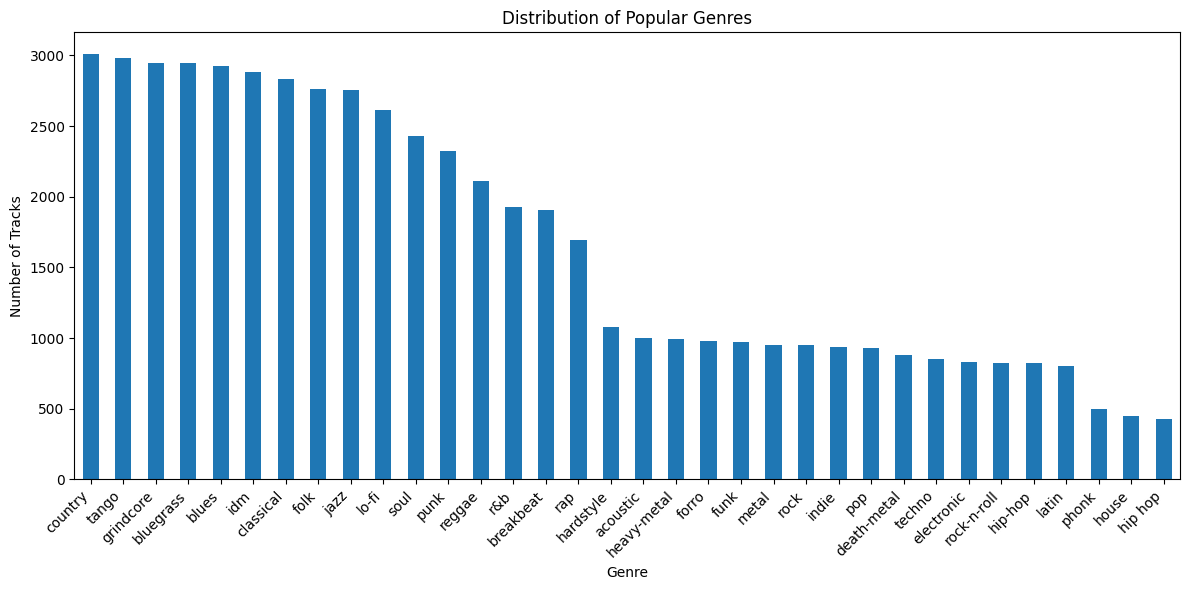

In [15]:
df = pd.read_csv('./final_dataset.csv')

import pandas as pd
import matplotlib.pyplot as plt

# 1. Define your set of popular genres
popular_genres = {
    'country', 'metal', 'heavy-metal', 'hardstyle',
    'blues', 'rap', 'hip hop', 'hip-hop', 'classical', 'folk',
    'jazz', 'lo-fi', 'soul', 'punk', 'r&b', 'latin',
    'rock', 'rock-n-roll', 'techno', 'pop', 'house', 'phonk',
    'indie', 'idm', 'reggae', 'funk', 'acid',
    'death-metal', 'bluegrass', 'acoustic', 'electronic',
    'tango', 'forro', 'breakbeat', 'grindcore'
}

# 2. (Re)load your CSV if needed:
# df = pd.read_csv('your_file.csv')

# 3. Filter to just the rows whose genre is in that set
df_filtered = df[df['genre'].isin(popular_genres)]

# 4. Count how many of each genre you have
genre_counts = df_filtered['genre'].value_counts()

# 5. Plot as a bar chart
plt.figure(figsize=(12,6))
genre_counts.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Number of Tracks')
plt.title('Distribution of Popular Genres')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Read File

In [2]:
import pandas as pd
tracks_info_df = pd.read_csv('./combined_dataset.csv')

# Download all preview mp3 files

In [ ]:
import os
import requests

# -- Prepare Download Directory --
download_folder = "audio_previews"
os.makedirs(download_folder, exist_ok=True)


for idx, row in tracks_info_df.iterrows():

    track_id = row['id']
    preview_url = row['preview']

    # Form the output filename for the preview
    output_filename = os.path.join(download_folder, f"{track_id}.mp3")
    
    # Skip if the file already exists
    if os.path.exists(output_filename):
        print(f"Preview for track {track_id} already exists. Skipping...")
        continue

    # Download the preview
    try:
        response = requests.get(preview_url, timeout=30)  # you can adjust timeout
        if response.status_code == 200:
            with open(output_filename, "wb") as f:
                f.write(response.content)
            print(f"Downloaded preview for track {track_id}")
        else:
            print(f"Failed to download track {track_id}: HTTP {response.status_code}")
    except Exception as e:
        print(f"Error downloading track {track_id}: {e}")


# Extract Track Features

In [3]:
import os
import pickle
import shutil
import librosa
import numpy as np


def summarize_feature(feature_array):
    """
    feature_array shape: [num_coeffs, num_frames]
    Returns: 1D numpy array containing mean, std, and median of each row.
    """
    means = np.mean(feature_array)
    stds = np.std(feature_array)
    medians = np.median(feature_array)

    return [means, stds, medians] 

def extract_features_librosa(file_path):

    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Extract features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    chroma_vqt = librosa.feature.chroma_vqt(y=y, sr=sr, intervals='equal')
    melspectogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12) # Numer of mfccs difference?
    rms = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwith = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y) 
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    poly_features = librosa.feature.poly_features(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zero_crossings = librosa.feature.zero_crossing_rate(y)
    
    # Estimate tempo and beats
    tempo = librosa.feature.tempo(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(y=y, sr=sr)
    fourier_tempogram = librosa.feature.fourier_tempogram(y=y, sr=sr)
    tempogram_ratio = librosa.feature.tempogram_ratio(y=y, sr=sr)

    track_features = [
        summarize_feature(mfccs),
        summarize_feature(chroma_stft),
        summarize_feature(chroma_cqt),
        summarize_feature(chroma_cens),
        summarize_feature(chroma_vqt),
        summarize_feature(melspectogram),
        summarize_feature(spectral_centroid),
        summarize_feature(spectral_bandwith),
        summarize_feature(spectral_contrast),
        summarize_feature(spectral_flatness),
        summarize_feature(spectral_rolloff),
        summarize_feature(poly_features),
        summarize_feature(tonnetz),
        summarize_feature(zero_crossings),
        summarize_feature(tempogram),
        summarize_feature(fourier_tempogram),
        summarize_feature(tempogram_ratio),
        summarize_feature(rms),
        np.ravel(tempo) # Flatten Tempo into an 1D array
    ]

    def flatten(track_features):
        return [feature for features in track_features for feature in features]

    return flatten(track_features)


folder_path = './audio_previews'
results_file = 'audio_features.pkl'

# Check if the features pickle file exists, if yes load it
if os.path.exists(results_file):
    with open(results_file, 'rb') as file:
        saved_data = pickle.load(file)
    X = saved_data.get('X', [])
    y_labels = saved_data.get('y_labels', [])
    processed_files = set(saved_data.get('processed_files', []))
    print(f"Loaded {len(processed_files)} processed tracks")
else:
    X = []
    y_labels = []
    processed_files = set()

all_files = [file for file in os.listdir(folder_path) if file.endswith('.mp3')]
total_files_count_left = len(set(all_files) - set(processed_files))
counter = 0
batch_counter = 0
batch_size = 10

id_to_genre = dict(zip(tracks_info_df['id'], tracks_info_df['genre']))

for file in all_files:

    if file in processed_files:
        continue

    counter += 1
    batch_counter += 1
    print(f'Processing file {counter}/{total_files_count_left}...')

    file_path = os.path.join(folder_path, file)
    file_id = os.path.splitext(file)[0]

    features = extract_features_librosa(file_path)
    X.append(features)

    try:
        #genre = tracks_info_df.loc[tracks_info_df['id'] == file_id, 'genre'].iloc[0]
        genre = id_to_genre.get(file_id, None)
        y_labels.append(genre)
    except IndexError:
        print("This should actually not happen :(, couldnt find genre in the pandas dataframe based on ID")
        y_labels.append(None)
    
    processed_files.add(file)

    if batch_counter >= batch_size:
        with open(results_file, 'wb') as file:
            pickle.dump({
                'X': X,
                'y_labels': y_labels,
                'processed_files': list(processed_files)
            }, file)
        batch_counter = 0
    if counter % 30 == 0:
        base, ext = os.path.splitext(results_file)
        backup_file = f"{base}_backup{ext}"

        shutil.copy(results_file, backup_file)


Loaded 22320 processed tracks
Processing file 1/78071...
Processing file 2/78071...
Processing file 3/78071...
Processing file 4/78071...
Processing file 5/78071...
Processing file 6/78071...
Processing file 7/78071...
Processing file 8/78071...
Processing file 9/78071...
Processing file 10/78071...
Processing file 11/78071...
Processing file 12/78071...
Processing file 13/78071...
Processing file 14/78071...
Processing file 15/78071...
Processing file 16/78071...
Processing file 17/78071...
Processing file 18/78071...
Processing file 19/78071...
Processing file 20/78071...
Processing file 21/78071...
Processing file 22/78071...
Processing file 23/78071...
Processing file 24/78071...
Processing file 25/78071...
Processing file 26/78071...
Processing file 27/78071...
Processing file 28/78071...
Processing file 29/78071...
Processing file 30/78071...
Processing file 31/78071...
Processing file 32/78071...
Processing file 33/78071...
Processing file 34/78071...
Processing file 35/78071...

KeyboardInterrupt: 

# Ectract with Essentia

In [ ]:
import os
import pickle
import shutil
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
import essentia
import essentia.standard as es
from tqdm import tqdm

# =============== Config ==================
folder_path = './audio_previews'
results_file = 'audio_features_new.pkl'
tracks_info_file = './data_combined_dominik_kaggle.csv'  # Your ID-Genre CSV
batch_size = 10
num_workers = 4  # number of threads
# ==========================================

lock = threading.Lock()

def extract_features_essentia(file_path):
    loader = es.MonoLoader(filename=file_path)
    audio = loader()

    # Pre-processing
    audio = es.FrameCutter(frameSize=2048, hopSize=1024)(audio)
    windowed = es.Windowing(type='hann')(audio)
    spectrum = es.Spectrum()(windowed)
    mfcc = es.MFCC(numberCoefficients=13)(spectrum)[1]
    
    # Aggregate statistics
    mean_mfcc = np.mean(mfcc, axis=0)
    std_mfcc = np.std(mfcc, axis=0)
    median_mfcc = np.median(mfcc, axis=0)

    # High-level features
    extractor = es.MusicExtractor(
        lowlevelStats=['mean', 'stdev'],
        rhythmStats=['mean', 'stdev'],
        tonalStats=['mean', 'stdev']
    )
    features, features_frames = extractor(file_path)

    # We'll use a flat vector of selected features
    flat_features = []
    
    # Pick important feature groups
    for group in ['lowlevel', 'rhythm', 'tonal']:
        for feature_name, value in features[group].items():
            if isinstance(value, (int, float, np.ndarray)):
                value = np.atleast_1d(value)
                flat_features.extend(value.tolist())

    # Add MFCC stats
    flat_features.extend(mean_mfcc.tolist())
    flat_features.extend(std_mfcc.tolist())
    flat_features.extend(median_mfcc.tolist())

    return np.array(flat_features)

def load_existing_data(results_file):
    if os.path.exists(results_file):
        with open(results_file, 'rb') as file:
            saved_data = pickle.load(file)
        print(f"Loaded {len(saved_data.get('processed_files', []))} processed tracks")
        return (
            saved_data.get('X', []),
            saved_data.get('y_labels', []),
            set(saved_data.get('processed_files', []))
        )
    return [], [], set()

def save_data(results_file, X, y_labels, processed_files):
    with open(results_file, 'wb') as file:
        pickle.dump({
            'X': X,
            'y_labels': y_labels,
            'processed_files': list(processed_files)
        }, file)

def process_file(file, id_to_genre):
    file_path = os.path.join(folder_path, file)
    file_id = os.path.splitext(file)[0]
    try:
        features = extract_features_essentia(file_path)
        genre = id_to_genre.get(file_id, None)
        return features, genre, file
    except Exception as e:
        print(f"Error processing {file}: {e}")
        return None, None, file

# Load CSV
tracks_info_df = pd.read_csv(tracks_info_file)
id_to_genre = dict(zip(tracks_info_df['id'].astype(str), tracks_info_df['genre']))

# Load previous results if any
X, y_labels, processed_files = load_existing_data(results_file)

all_files = [file for file in os.listdir(folder_path) if file.endswith('.mp3')]
files_to_process = list(set(all_files) - processed_files)
total_files = len(files_to_process)
batch_counter = 0

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(process_file, file, id_to_genre): file for file in files_to_process}
    
    # Add tqdm progress bar
    with tqdm(total=total_files, desc="Processing audio files") as pbar:
        for future in as_completed(futures):
            features, genre, file = future.result()

            if features is not None:
                with lock:
                    X.append(features)
                    y_labels.append(genre)
                    processed_files.add(file)
            
            batch_counter += 1
            pbar.update(1)

            if batch_counter >= batch_size:
                with lock:
                    save_data(results_file, X, y_labels, processed_files)
                    batch_counter = 0

# Final save
save_data(results_file, X, y_labels, processed_files)
print("All done!")


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done


Error processing 0ett0qCHbl0vdSRFhRSkMc.mp3: "no key found named 'lowlevel'"
Error processing 1OwWdf12e02HeIQvUsLUdD.mp3: "no key found named 'lowlevel'"
Error processing 5rHOjo1bvjdUYH9ViGclLH.mp3: "no key found named 'lowlevel'"
Error processing 6CmuT4GB0mCTviUq2jB9Fe.mp3: "no key found named 'lowlevel'"
Error processing 2rJY1HlLcOXsQYMPUnhQxa.mp3: "no key found named 'lowlevel'"


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

Error processing 4pAXu3mUCsco6jhaTypLnC.mp3: "no key found named 'lowlevel'"
Error processing 5LV2hCbhm2lh4a4NbjCJqd.mp3: "no key found named 'lowlevel'"
Error processing 5ygEUpyZy5qtZ1423zymBW.mp3: "no key found named 'lowlevel'"


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done


Error processing 7mEm1N1cDErUOpFWic3TIZ.mp3: "no key found named 'lowlevel'"
Error processing 7Bp9rKKDf7Ay1LBNmEU2Bl.mp3: "no key found named 'lowlevel'"
Error processing 7fe7qXjvlXDUs8HiPRSnbw.mp3: "no key found named 'lowlevel'"
Error processing 77ou4xwREuG6rqriGgWnpd.mp3: "no key found named 'lowlevel'"


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

Error processing 2HKRFTnJtLFn15K8zCcsof.mp3: "no key found named 'lowlevel'"
Error processing 6zQpBVXilFdWJnlDlNE5jO.mp3: "no key found named 'lowlevel'"
Error processing 3CI0tvulxpMSMAPNCgqTMU.mp3: "no key found named 'lowlevel'"
Error processing 4xCM9zy2m4MfsC8EP00rBz.mp3: "no key found named 'lowlevel'"
Error processing 551xyaSJsg8hILXFq9JdST.mp3: "no key found named 'lowlevel'"
Error processing 7z994LVEvJTvPYkAuToucs.mp3: "no key found named 'lowlevel'"
Error processing 6uzwDnvsPrQM8eNBeWReMy.mp3: "no key found named 'lowlevel'"
Error processing 6BjDuBO6OhHGUGG7vcVnAW.mp3: "no key found named 'lowlevel'"
Error processing 2mlFkeGCkKcEYqp7MAdRlm.mp3: "no key found named 'lowlevel'"
Error processing 03RqhjDOozIMIAlhILrvLb.mp3: "no key found named 'lowlevel'"
Error processing 2IOuVaLf8rrpMYZKc0Pt5l.mp3: "no key found named 'lowlevel'"
Error processing 3jvqXU6Keuwe1Fifs1YNdo.mp3: "no key found named 'lowlevel'"


# Extract track features multithreaded

In [3]:
import os
import pickle
import shutil
import librosa
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm  # Optional for progress bars

# Your existing summarize and extract function
# (Make sure extract_features_librosa is top-level for multiprocessing)

def summarize_feature(feature_array):
    means = np.mean(feature_array)
    stds = np.std(feature_array)
    medians = np.median(feature_array)
    return [means, stds, medians] 

def flatten(track_features):
    return [feature for features in track_features for feature in features]

def extract_features_librosa(file_path):
    y, sr = librosa.load(file_path, sr=None)
    features = [
        summarize_feature(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)),
        summarize_feature(librosa.feature.chroma_stft(y=y, sr=sr)),
        summarize_feature(librosa.feature.chroma_cqt(y=y, sr=sr)),
        summarize_feature(librosa.feature.chroma_cens(y=y, sr=sr)),
        summarize_feature(librosa.feature.chroma_vqt(y=y, sr=sr, intervals='equal')),
        summarize_feature(librosa.feature.melspectrogram(y=y, sr=sr)),
        summarize_feature(librosa.feature.spectral_centroid(y=y, sr=sr)),
        summarize_feature(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        summarize_feature(librosa.feature.spectral_contrast(y=y, sr=sr)),
        summarize_feature(librosa.feature.spectral_flatness(y=y)),
        summarize_feature(librosa.feature.spectral_rolloff(y=y, sr=sr)),
        summarize_feature(librosa.feature.poly_features(y=y, sr=sr)),
        summarize_feature(librosa.feature.tonnetz(y=y, sr=sr)),
        summarize_feature(librosa.feature.zero_crossing_rate(y)),
        summarize_feature(librosa.feature.tempogram(y=y, sr=sr)),
        summarize_feature(librosa.feature.fourier_tempogram(y=y, sr=sr)),
        summarize_feature(librosa.feature.tempogram_ratio(y=y, sr=sr)),
        summarize_feature(librosa.feature.rms(y=y)),
        np.ravel(librosa.feature.tempo(y=y, sr=sr))
    ]
    return flatten(features)

def process_file(file, folder_path, id_to_genre):
    try:
        file_path = os.path.join(folder_path, file)
        file_id = os.path.splitext(file)[0]
        features = extract_features_librosa(file_path)
        genre = id_to_genre.get(file_id, None)
        return features, genre, file
    except Exception as e:
        print(f"Error processing {file}: {e}")
        return None, None, file

# Load pickle
results_file = 'audio_features.pkl'
if os.path.exists(results_file):
    with open(results_file, 'rb') as file:
        saved_data = pickle.load(file)
    X = saved_data.get('X', [])
    y_labels = saved_data.get('y_labels', [])
    processed_files = set(saved_data.get('processed_files', []))
else:
    X = []
    y_labels = []
    processed_files = set()

folder_path = './audio_previews'
all_files = [f for f in os.listdir(folder_path) if f.endswith('.mp3')]
files_to_process = [f for f in all_files if f not in processed_files]

# This must be defined before! (You're using a DataFrame)
id_to_genre = dict(zip(tracks_info_df['id'], tracks_info_df['genre']))

batch_size = os.cpu_count() or 4
backup_interval = 100
counter = 0

with tqdm(total=len(files_to_process), desc="Processing files", unit="file") as pbar:
    with ProcessPoolExecutor(max_workers=batch_size) as executor:
        futures = []
        for i in range(0, len(files_to_process), batch_size):
            batch = files_to_process[i:i+batch_size]
            futures = [executor.submit(process_file, file, folder_path, id_to_genre) for file in batch]

            for future in futures:
                features, genre, file = future.result()
                if features is not None:
                    X.append(features)
                    y_labels.append(genre)
                    processed_files.add(file)
                    counter += 1
                
                pbar.update(1)

            # Save after each batch
            with open(results_file, 'wb') as f:
                pickle.dump({
                    'X': X,
                    'y_labels': y_labels,
                    'processed_files': list(processed_files)
                }, f)

            if counter % backup_interval == 0:
                backup_file = results_file.replace(".pkl", "_backup.pkl")
                shutil.copy(results_file, backup_file)
                print(f"Backup created at {backup_file}")

print(f"Done processing {counter} new tracks.")


Processing files:   2%|▏         | 297/15001 [07:25<3:38:31,  1.12file/s] 

Backup created at audio_features_backup.pkl


Processing files:   4%|▍         | 600/15001 [14:44<2:19:39,  1.72file/s] 

Backup created at audio_features_backup.pkl


Processing files:   6%|▌         | 898/15001 [21:57<2:50:17,  1.38file/s] 

Backup created at audio_features_backup.pkl


Processing files:   8%|▊         | 1189/15001 [29:13<9:50:08,  2.56s/file]

Backup created at audio_features_backup.pkl


Processing files:  10%|▉         | 1496/15001 [36:40<4:03:40,  1.08s/file] 

Backup created at audio_features_backup.pkl


Processing files:  12%|█▏        | 1800/15001 [44:09<2:15:54,  1.62file/s] 

Backup created at audio_features_backup.pkl


Processing files:  14%|█▍        | 2093/15001 [51:40<5:33:41,  1.55s/file]

Backup created at audio_features_backup.pkl


Processing files:  16%|█▌        | 2390/15001 [59:03<6:37:17,  1.89s/file]

Backup created at audio_features_backup.pkl


Processing files:  18%|█▊        | 2699/15001 [1:06:23<3:01:16,  1.13file/s]

Backup created at audio_features_backup.pkl


Processing files:  20%|█▉        | 2998/15001 [1:13:41<3:11:02,  1.05file/s]

Backup created at audio_features_backup.pkl


Processing files:  22%|██▏       | 3300/15001 [1:20:55<2:06:58,  1.54file/s]

Backup created at audio_features_backup.pkl


Processing files:  24%|██▍       | 3599/15001 [1:28:12<2:21:58,  1.34file/s]

Backup created at audio_features_backup.pkl


Processing files:  26%|██▌       | 3898/15001 [1:35:31<2:35:59,  1.19file/s]

Backup created at audio_features_backup.pkl


Processing files:  28%|██▊       | 4198/15001 [1:42:47<3:09:13,  1.05s/file]

Backup created at audio_features_backup.pkl


Processing files:  30%|██▉       | 4498/15001 [1:50:09<2:48:34,  1.04file/s]

Backup created at audio_features_backup.pkl


Processing files:  32%|███▏      | 4797/15001 [1:57:29<2:33:51,  1.11file/s]

Backup created at audio_features_backup.pkl


Processing files:  34%|███▍      | 5097/15001 [2:04:50<1:44:04,  1.59file/s]

Backup created at audio_features_backup.pkl


Processing files:  36%|███▌      | 5393/15001 [2:12:14<3:36:07,  1.35s/file]

Backup created at audio_features_backup.pkl


Processing files:  38%|███▊      | 5700/15001 [2:19:36<2:16:34,  1.13file/s]

Backup created at audio_features_backup.pkl


Processing files:  40%|███▉      | 5996/15001 [2:26:57<2:25:10,  1.03file/s]

Backup created at audio_features_backup.pkl


Processing files:  42%|████▏     | 6296/15001 [2:34:21<2:35:42,  1.07s/file]

Backup created at audio_features_backup.pkl


Processing files:  44%|████▍     | 6591/15001 [2:41:45<3:47:58,  1.63s/file]

Backup created at audio_features_backup.pkl


Processing files:  46%|████▌     | 6893/15001 [2:49:09<3:43:53,  1.66s/file]

Backup created at audio_features_backup.pkl


Processing files:  48%|████▊     | 7199/15001 [2:56:36<2:08:11,  1.01file/s]

Backup created at audio_features_backup.pkl


Processing files:  50%|████▉     | 7494/15001 [3:04:00<2:25:33,  1.16s/file]

Backup created at audio_features_backup.pkl


Processing files:  52%|█████▏    | 7798/15001 [3:11:28<1:46:14,  1.13file/s]

Backup created at audio_features_backup.pkl


Processing files:  54%|█████▍    | 8100/15001 [3:18:58<1:15:44,  1.52file/s]

Backup created at audio_features_backup.pkl


Processing files:  56%|█████▌    | 8396/15001 [3:26:33<2:20:55,  1.28s/file]

Backup created at audio_features_backup.pkl


Processing files:  58%|█████▊    | 8698/15001 [3:34:21<1:38:01,  1.07file/s]

Backup created at audio_features_backup.pkl


Processing files:  60%|█████▉    | 8990/15001 [3:42:09<3:27:39,  2.07s/file]

Backup created at audio_features_backup.pkl


Processing files:  62%|██████▏   | 9297/15001 [3:49:59<1:50:31,  1.16s/file]

Backup created at audio_features_backup.pkl


Processing files:  64%|██████▍   | 9598/15001 [3:57:57<1:37:09,  1.08s/file]

Backup created at audio_features_backup.pkl


Processing files:  66%|██████▌   | 9893/15001 [4:06:12<2:19:02,  1.63s/file]

Backup created at audio_features_backup.pkl


Processing files:  68%|██████▊   | 10199/15001 [4:14:26<1:16:35,  1.04file/s]

Backup created at audio_features_backup.pkl


Processing files:  70%|██████▉   | 10489/15001 [4:22:42<3:32:36,  2.83s/file]

Backup created at audio_features_backup.pkl


Processing files:  72%|███████▏  | 10797/15001 [4:30:53<1:07:18,  1.04file/s]

Backup created at audio_features_backup.pkl


Processing files:  74%|███████▍  | 11092/15001 [4:39:11<2:04:50,  1.92s/file]

Backup created at audio_features_backup.pkl


Processing files:  76%|███████▌  | 11400/15001 [4:47:20<57:53,  1.04file/s]  

Backup created at audio_features_backup.pkl


Processing files:  78%|███████▊  | 11698/15001 [4:55:02<54:39,  1.01file/s]  

Backup created at audio_features_backup.pkl


Processing files:  80%|███████▉  | 11997/15001 [5:02:41<49:10,  1.02file/s]  

Backup created at audio_features_backup.pkl


Processing files:  82%|████████▏ | 12298/15001 [5:10:23<30:49,  1.46file/s]  

Backup created at audio_features_backup.pkl


Processing files:  84%|████████▍ | 12599/15001 [5:18:05<29:42,  1.35file/s]  

Backup created at audio_features_backup.pkl


Processing files:  85%|████████▌ | 12757/15001 [5:22:23<1:17:36,  2.08s/file]/home/agres/projects/predictify/.venv/lib/python3.10/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing files:  86%|████████▌ | 12898/15001 [5:25:46<29:59,  1.17file/s]  

Backup created at audio_features_backup.pkl


Processing files:  88%|████████▊ | 13198/15001 [5:33:27<23:31,  1.28file/s]  

Backup created at audio_features_backup.pkl


Processing files:  90%|████████▉ | 13499/15001 [5:41:12<22:11,  1.13file/s]  

Backup created at audio_features_backup.pkl


Processing files:  92%|█████████▏| 13800/15001 [5:48:57<15:00,  1.33file/s]

Backup created at audio_features_backup.pkl


Processing files:  94%|█████████▍| 14089/15001 [5:56:46<28:30,  1.88s/file]

Backup created at audio_features_backup.pkl


Processing files:  96%|█████████▌| 14396/15001 [6:04:34<11:53,  1.18s/file]

Backup created at audio_features_backup.pkl


Processing files:  98%|█████████▊| 14698/15001 [6:12:21<05:23,  1.07s/file]

Backup created at audio_features_backup.pkl


Processing files: 100%|█████████▉| 14995/15001 [6:20:07<00:07,  1.19s/file]

Backup created at audio_features_backup.pkl


Processing files: 100%|██████████| 15001/15001 [6:20:29<00:00,  1.52s/file]

Done processing 15001 new tracks.


In [1]:
# Merge two pkl files

import pickle
import os

def merge_pickles(file1, file2, output_file):
    with open(file1, 'rb') as f1, open(file2, 'rb') as f2:
        data1 = pickle.load(f1)
        data2 = pickle.load(f2)

    # Merge the data
    merged_data = {
        'X': data1['X'] + data2['X'],
        'y_labels': data1['y_labels'] + data2['y_labels'],
        'processed_files': list(set(data1['processed_files'] + data2['processed_files']))
    }

    # Save the merged data
    with open(output_file, 'wb') as f_out:
        pickle.dump(merged_data, f_out)

# Usage
file1 = 'audio_features.pkl'
file2 = 'audio_features_chris.pkl'
output_file = 'audio_features_merged.pkl'

merge_pickles(file1, file2, output_file)